In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import proplot as pplt
from scipy import linalg
from mod_LIM import *

In [2]:
# RMM
f = '/data3/kinya/pyworks/AR/data/RMM_DJF.csv'
df = pd.read_csv(f, index_col=0, parse_dates=True)
df = df['1981-12-01':'2019-12-29']

In [3]:
f = 'data/state7.5dm.anom.DJF.1981_2019.nc'
ds = xr.open_dataset(f)

In [4]:
# select regions
dsr = xr.merge([ds.sel(lat=slice(20, 80), lon=slice(120, 270))[['sf850', 'sf250', 'IVT']],
                ds.sel(lat=slice(-15, 15))[['olr', 'sst']]])

In [5]:
# EOF
# num_eigs = pd.DataFrame({'ne': [30, 30, 30, 30], 
#                          'variables': [['sf850', 'sf250'], 'IVT', 'olr', 'sst']},
#                         index=['sf', 'IVT', 'olr', 'sst'])

num_eigs = pd.DataFrame({'ne': [18, 21, 11], 
                         'variables': [['sf850', 'sf250', 'IVT'], 'olr', 'sst']},
                        index=['ex', 'olr', 'sst'])

pc, eof, std_factor, pca_score, std_factor_multi = calc_pc_eof(dsr, num_eigs)

# Truncated field
dsa_tr = proj_ori(pc, eof, num_eigs, std_factor)

# make a state vector
x = pc_to_state(pc)
n = x.shape[0]

# LIM
tau0 = 4
G = calc_lim_g(x, tau0)
L = linalg.logm(G) / tau0

In [38]:
# ENMs
enm, eigvecs = calc_enms(x, G, tau0, eof, num_eigs, std_factor)

# # norms
# wgt = np.cos(np.deg2rad(dsr.lat))
# enm['sf250norm'] = (np.abs(enm['sf250'])**2).weighted(wgt).sum(dim=['lat', 'lon'])**0.5
# enm['olrnorm'] = (np.abs(enm['olr'])**2).weighted(wgt).sum(dim=['lat', 'lon'])**0.5

# # sort by OLR norm
# eigvecs = eigvecs.sortby(enm['olrnorm'], ascending=False)
# enm = enm.sortby('olrnorm', ascending=False)

# sort first by period, then by e-folding time
eigvecs = eigvecs.sortby([np.abs(enm['period']), enm['e_folding']])
enm = enm.sortby([np.abs(enm['period']), enm['e_folding']])

# reset enm index
eigvecs = eigvecs.assign_coords(enm = range(enm.enm.size))
enm = enm.assign_coords(enm = range(enm.enm.size))

# extract positive freq
enmp = enm.sel(enm = enm['freq'] >= 0)
enm_nonst_p = enmp.sel(enm=enmp['freq'] > 0).enm.data
enm_st_p = enmp.sel(enm=enmp['freq'] == 0).enm.data

/data3/kinya/pyworks/LIM/MERRA2/mod_LIM.py:816: RuntimeWarning: divide by zero encountered in true_divide
  'period': (('enm'), 2*np.pi/omega),


In [50]:
rmms = np.arange(1, 9)
tau = 7    # Target growth period
n_leads = 60

lst_p = []
lst_mu = []
lst_fcst = []
lst_z_fcst = []
for rmm in rmms:
    # target norm
    tt = df[df.phase == rmm].index
    com_pc = pc.sel(time=tt).mean(dim='time')

    # Set to zero
    vlst_off = ['ex', 'sst']
    #com_pc[vlst_off] = xr.where(True, 0, com_pc[vlst_off])
    com_pc[vlst_off] *= 0

    n = pc_to_state(com_pc)

    # Calculate growth rate for different tau
    taus = np.arange(1, 31)

    lst1 = []
    lst2 = []
    for tau in taus:
        p, mu = calc_optimal_growth(L, n, tau)
        lst1.append(p)
        lst2.append(mu)
    p = xr.concat(lst1, pd.Index(taus, name='tau')).transpose('feature', ...)
    mu = xr.DataArray(lst2, dims=['tau'], coords=[taus])

    # Forecast
    x_fcst = calc_lim_fcst(p.sel(tau=tau), tau0, G, n_leads)
    pc_fcst = state_to_pc(x_fcst)

    # Project forecasted values to the original space
    fcst = proj_ori(pc_fcst, eof, num_eigs, std_factor)

    # project to enm space
    z_fcst = proj_x_to_z(x_fcst.transpose('feature', ...), eigvecs)
    
    # append
    lst_p.append(p)
    lst_mu.append(mu)
    lst_fcst.append(fcst)
    lst_z_fcst.append(z_fcst)
    
p = xr.concat(lst_p, pd.Index(rmms, name='rmm'))
mu = xr.concat(lst_mu, pd.Index(rmms, name='rmm'))
fcst = xr.concat(lst_fcst, pd.Index(rmms, name='rmm'))
z_fcst = xr.concat(lst_z_fcst, pd.Index(rmms, name='rmm'))

# average
wgt = np.cos(np.deg2rad(fcst.lat))
fcst_eq = fcst.sel(lat=slice(-15, 15)).weighted(wgt).mean(dim='lat')
    
z_fcst = xr.merge([z_fcst.rename('z'), enm[['e_folding', 'period', 'freq']]])
z_fcst['zabs'] = np.abs(z_fcst['z'])
z_fcstp = z_fcst.sel(enm=z_fcst['freq'] >= 0)

# plot

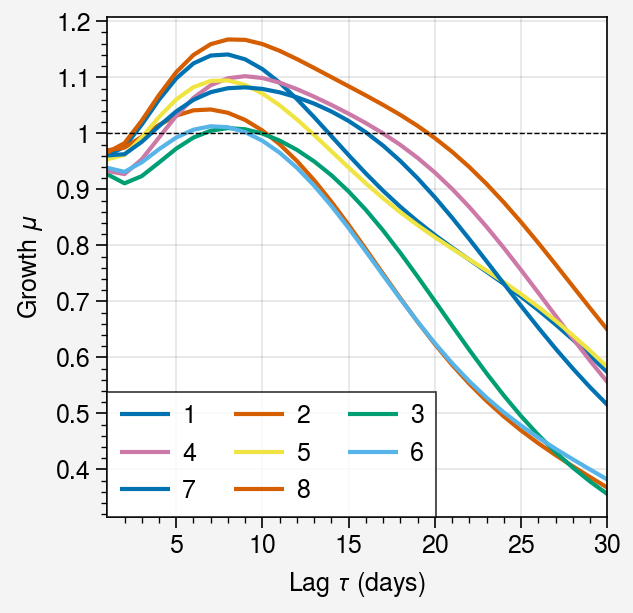

In [49]:
rmm = 3
fig, ax = pplt.subplots()
ax.plot(mu.T)
ax.legend()
ax.axhline(1, c='k', ls='--', lw=0.5)
ax.format(ylabel=r'Growth $\mathit{\mu}$', 
          xlabel=r'Lag $\mathit{\tau}$ (days)',
         xlim=(1, 30))
#fig.save('png/optimal_mjo_growth.png')

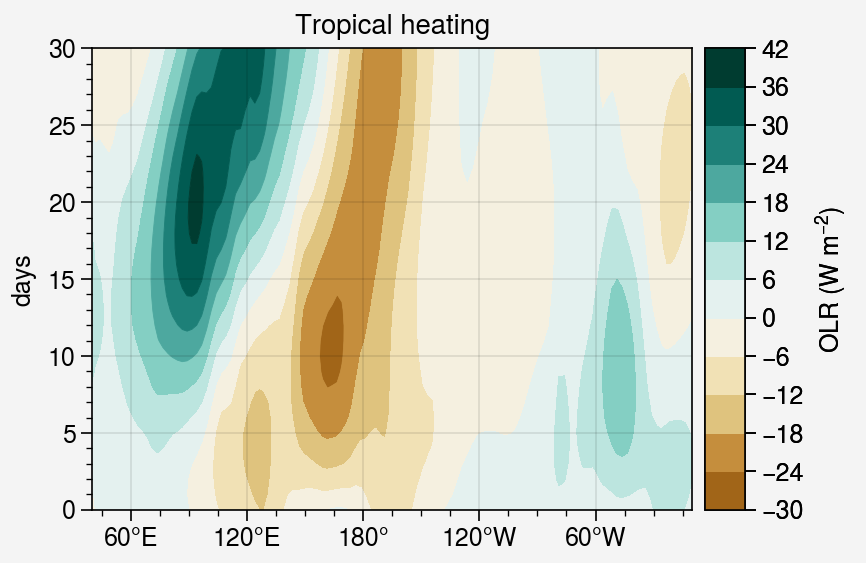

In [51]:
var = 'olr'
fig, ax = pplt.subplots(axwidth=3, refaspect=1.3)
m = ax.contourf(fcst_eq.sel(rmm=rmm)[var], norm='diverging', cmap='BrBG')
ax.colorbar(m, label=r'OLR $(W\ m^{-2})$')
ax.format(title='Tropical heating',
          xformatter='deglon', xlim=(40, 350), 
          xlocator=range(0,360,60), xlabel='',
          ylim=(0, 30), ylabel='days')
fig.save(f'png/optimal_mjo_{var}_eq.png')

ValueError: Input shapes x (36,) and y (8,) must match z centers (8, 36, 144) or z borders (9, 37, 145).

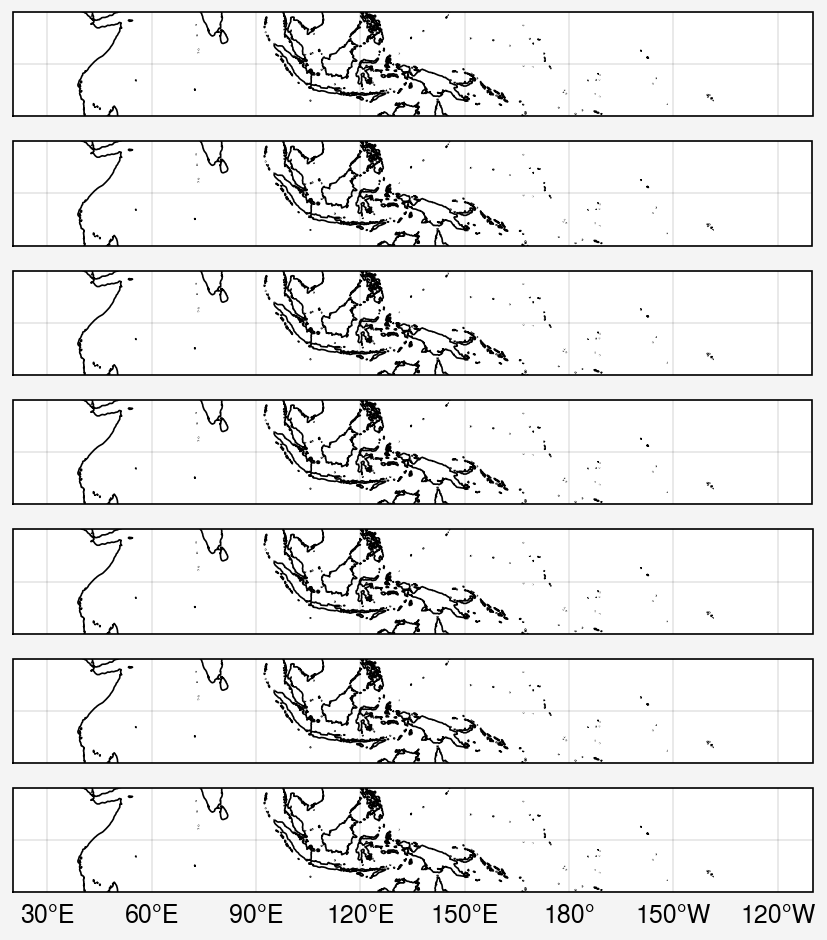

In [52]:
v = 30
var = 'olr'
fig, axs = pplt.subplots(axwidth=4, nrows=7, proj='cyl', proj_kw={'lon_0': 180})

axs.format(coast=True, lonlim=(20, 250), latlim=(-15, 15), latlocator=15)
axs[-1,:].format(lonlabels=True)
#axs[:,0].format(latlabels=True)

for i, ax in enumerate(axs):
    d = 5 * i
       
    m = ax.contourf(fcst.sel(lead=d)[var], norm='diverging', 
                    levels=np.linspace(-90, 90, 13), extend='both',
                    cmap='BrBG', globe=True)
    #ax.colorbar(m)
    ax.format(ultitle=f'Day {d}')
fig.colorbar(m, label=r'OLR $(W\ m^{-2})$')
#fig.save(f'png/optimal_mjo_{var}.png')

In [ ]:
fig, axs = pplt.subplots(nrows=2, ncols=2, axwidth=3, refaspect=2)

for i, ax in enumerate(axs):
    rmm = 2*i+1
    ax.plot(z_fcst.sel(rmm=rmm, lead=0)['zabs'], ls='None', marker='.', label='0 d')
    #ax.plot(z_fcst.sel(lead=10)['zabs'], ls='None', marker='.', label='10 d')
    ax.format(ltitle=f'phase {rmm}')

#ax.legend()
axs.format(ylabel = r'$|z_i|$', xlabel='Index')

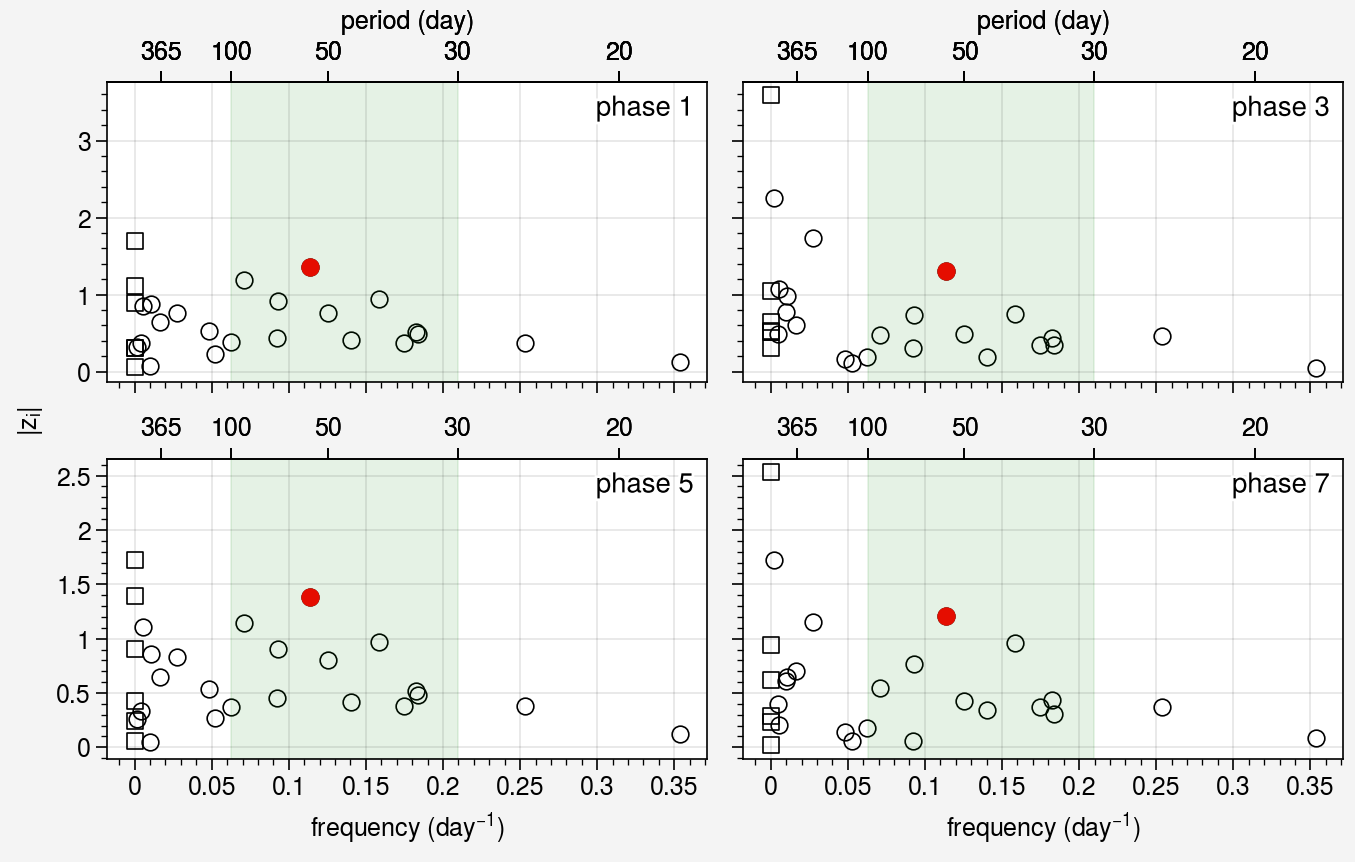

In [53]:
m = 'o'
lead_mjo_enmp = 16

fig, axs = pplt.subplots(nrows=2, ncols=2, axwidth=3, refaspect=2, spanx=0)

for i, ax in enumerate(axs):
    rmm = 2*i+1
    zabs = z_fcstp.sel(rmm=rmm, lead=0)['zabs']
    thres = zabs.mean() + 1 * zabs.std()
    ax.scatter(enmp.sel(enm=enm_st_p)['freq'], zabs.sel(enm=enm_st_p), 
               ec='k', fc='None', m='s')
    ax.scatter(enmp.sel(enm=enm_nonst_p)['freq'], zabs.sel(enm=enm_nonst_p), 
               ec='k', fc='None', m=m)

    # ax.scatter(enmp.sel(enm=mjo_enmp)['freq'], zabs.sel(enm=mjo_enmp), 
    #            ec='r', m=m, fc='None')
    ax.scatter(enmp.sel(enm=lead_mjo_enmp)['freq'], zabs.sel(enm=lead_mjo_enmp), 
               c='r', m=m)
    #ax.axhline(thres, c='k', ls='--', lw=0.5)
    ax.axvspan(2*np.pi/100, 2*np.pi/30, color='g', alpha=0.1)
    
    ax.format(urtitle=f'phase {rmm}')

axs.dualx(lambda x: 2*np.pi/x, locator=[20, 30, 50, 100, 365])
axs[0, :].dualx(lambda x: 2*np.pi/x, label='period (day)', locator=[20, 30, 50, 100, 365])

axs.format(ylabel=r'$|z_i|$', xlabel=r'frequency $(day^{-1})$')

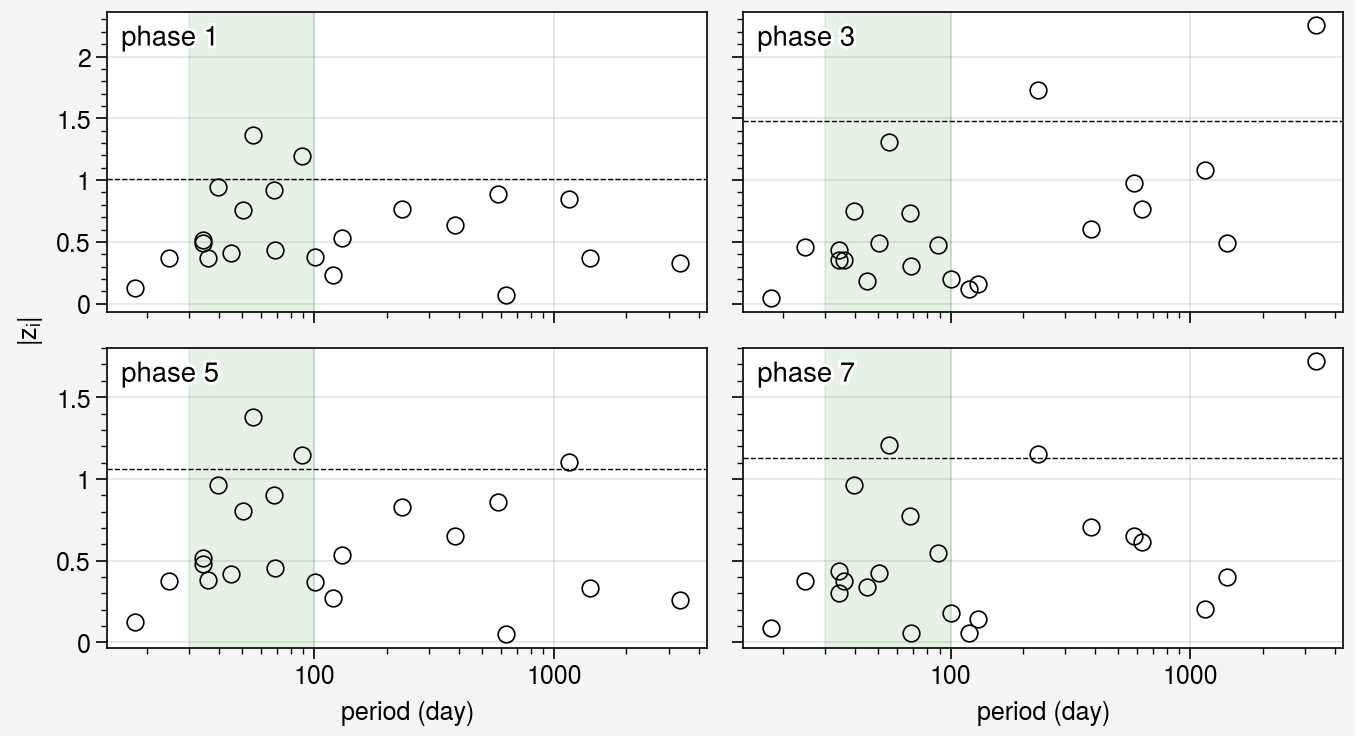

In [30]:
m = 'o'
fig, axs = pplt.subplots(nrows=2, ncols=2, axwidth=3, refaspect=2, spanx=0)

for i, ax in enumerate(axs):
    rmm = 2*i+1
    zabs = z_fcstp.sel(rmm=rmm, lead=0)['zabs']
    thres = zabs.mean() + 1 * zabs.std()
    ax.scatter(enmp['period'], zabs, ec='k', fc='None', m=m)
    #ax.axhline(thres, c='k', ls='--', lw=0.5)
    ax.axvspan(30, 100, color='g', alpha=0.1)
    
    ax.format(ultitle=f'phase {rmm}')

axs.format(ylabel=r'$|z_i|$', xlabel='period (day)', xscale='log')

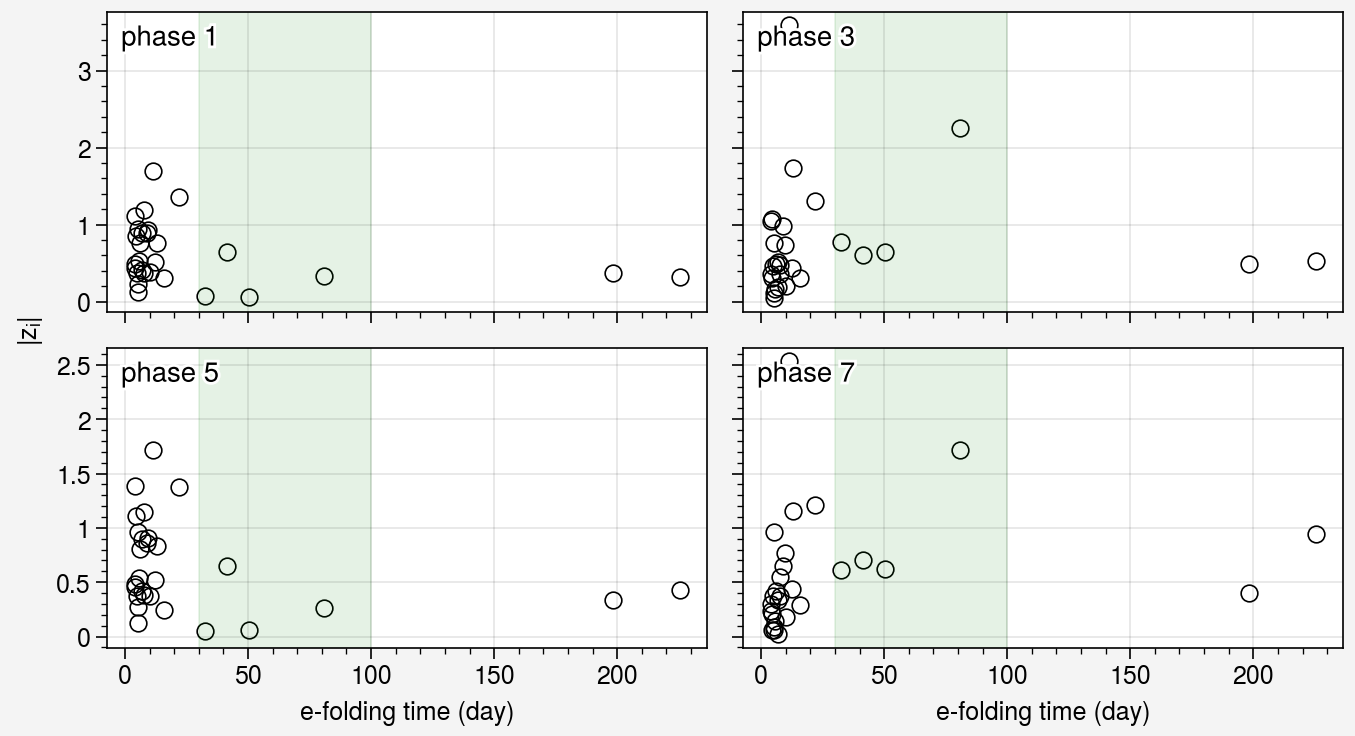

In [31]:
m = 'o'
fig, axs = pplt.subplots(nrows=2, ncols=2, axwidth=3, refaspect=2, spanx=0)

for i, ax in enumerate(axs):
    rmm = 2*i+1
    zabs = z_fcstp.sel(rmm=rmm, lead=0)['zabs']
    thres = zabs.mean() + 1 * zabs.std()
    ax.scatter(enmp['e_folding'], zabs, ec='k', fc='None', m=m)
    #ax.axhline(thres, c='k', ls='--', lw=0.5)
    ax.axvspan(30, 100, color='g', alpha=0.1)
    
    ax.format(ultitle=f'phase {rmm}')

axs.format(ylabel=r'$|z_i|$', xlabel='e-folding time (day)')

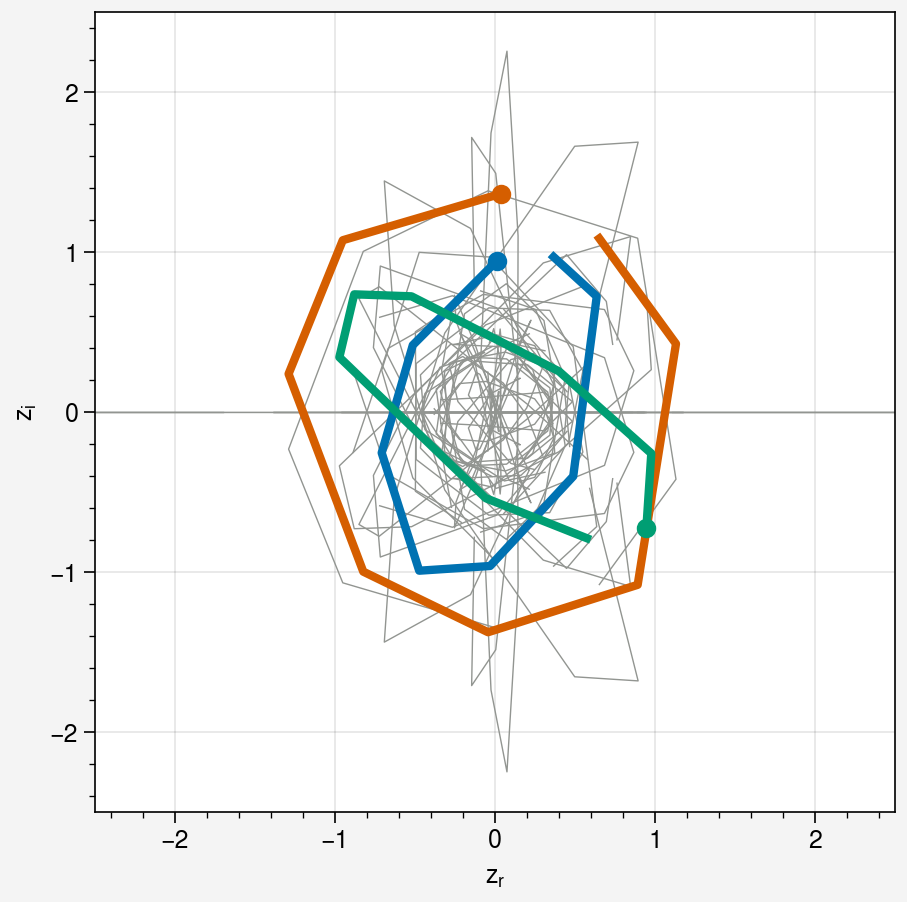

In [54]:
mjo_enmp = [10, 16, 22]

fig, ax = pplt.subplots(axwidth=4)
#ax.axvline(0, c='k', lw=.5)
#ax.axhline(0, c='k', lw=.5)

ax.plot(z_fcst.sel(lead=0)['z'].real, z_fcst.sel(lead=0)['z'].imag, c='gray', lw=.5)
ax.plot(z_fcst.sel(lead=0, enm=mjo_enmp)['z'].real, z_fcst.sel(lead=0, enm=mjo_enmp)['z'].imag,
       lw=3, m='o', markevery=[0])

# circle1 = plt.Circle((0, 0), .1, color='k', fill=False, lw=.5, ls='--')
# ax.add_artist(circle1)

ax.format(xlim=(-2.5, 2.5), ylim=(-2.5, 2.5),
          xlabel=r'$z_r$', ylabel=r'$z_i$')

In [32]:
print('Dominant ENM modes:')
for rmm in rmms:
    print(z_fcst.enm.sortby(z_fcst.sel(rmm=rmm, lead=0)['zabs'], ascending=False).data[:21])
    #print(z_fcstp.enm.sortby(z_fcstp.sel(rmm=rmm, lead=0)['zabs'], ascending=False).data[:18])

Dominant ENM modes:
[46 17 16 23 22 44 10 11 19 18 45 35 34 38 39 30 31 14 15 33 32]
[46 31 30 43 42 17 16 35 34 44 23 22 38 39 45 18 19 14 15 10 11]
[46 42 43 31 30 17 16 38 39 44 35 34 37 36 11 10 18 19 48 32 33]
[16 17 43 42 11 10 19 18 23 22 32 33 49 15 14 31 30 34 35  7  6]
[46 44 17 16 23 22 38 39 10 11 19 18 45 34 35 31 30 14 15 33 32]
[46 31 30 42 43 17 16 44 35 34 38 39 23 22 45 18 19 14 15 11 10]
[46 43 42 16 17 31 30 11 10 49 18 19 32 33 34 35 48 37 36 22 23]
[16 17 11 10 23 22 19 18 44 43 42 32 33 49 15 14 39 38 45 46  7]


In [26]:
z_fcst

<xarray.Dataset>
Dimensions:    (enm: 50, lead: 61, rmm: 8)
Coordinates:
  * enm        (enm) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * lead       (lead) int64 0 1 2 3 4 5 6 7 8 9 ... 52 53 54 55 56 57 58 59 60
  * rmm        (rmm) int64 1 2 3 4 5 6 7 8
Data variables:
    z          (rmm, enm, lead) complex128 (-0.03034567954198957-0.1193095017...
    e_folding  (enm) float64 5.304 5.304 4.945 4.945 ... 11.2 15.93 50.26 225.5
    period     (enm) float64 17.76 -17.76 24.79 -24.79 34.24 ... inf inf inf inf
    freq       (enm) float64 0.3537 -0.3537 0.2534 -0.2534 ... 0.0 0.0 0.0 0.0
    zabs       (rmm, enm, lead) float64 0.1231 0.102 0.08444 ... 0.5518 0.5494

In [25]:
zabs

<xarray.Dataset>
Dimensions:    (enm: 50)
Coordinates:
  * enm        (enm) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    lead       int64 0
    rmm        int64 1
Data variables:
    z          (enm) float64 0.1231 0.1231 0.3734 ... 0.3054 0.06293 0.3125
    e_folding  (enm) float64 5.304 5.304 4.945 4.945 ... 11.2 15.93 50.26 225.5
    period     (enm) float64 17.76 17.76 24.79 24.79 34.24 ... inf inf inf inf
    freq       (enm) float64 0.3537 0.3537 0.2534 0.2534 ... 0.0 0.0 0.0 0.0
    zabs       (enm) float64 0.1231 0.1231 0.3734 ... 0.3054 0.06293 0.3125